In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import sys
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms as T

functions_path = os.path.abspath(os.path.join('..', 'Functions'))
sys.path.append(functions_path)

from Pytorch_lightning import get_model, SegmentationModel, evaluation
from functions import load_images

images_dir = '../Datas/Airbus_images_Tests/'
images = load_images(images_dir, 'jpg')
images = np.array([img.astype(np.float32) for img in images])

Loading images: 100%|██████████| 8/8 [00:00<00:00, 71.60it/s]


Loading predictions:   0%|          | 0/8 [00:00<?, ?it/s]

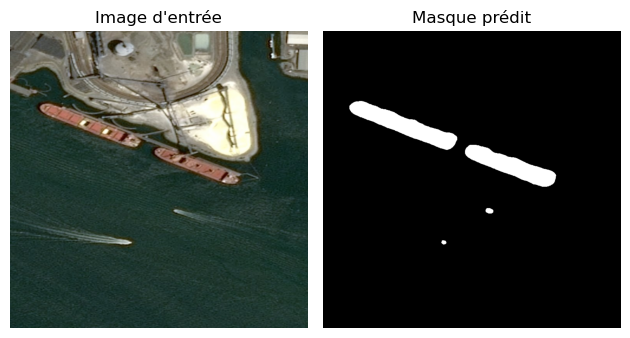

Loading predictions:  12%|█▎        | 1/8 [00:01<00:12,  1.74s/it]

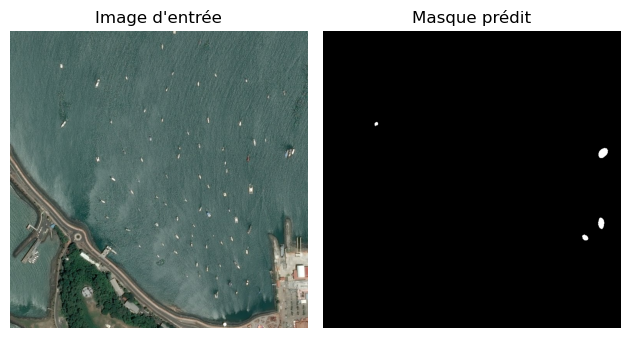

Loading predictions:  25%|██▌       | 2/8 [00:03<00:10,  1.79s/it]

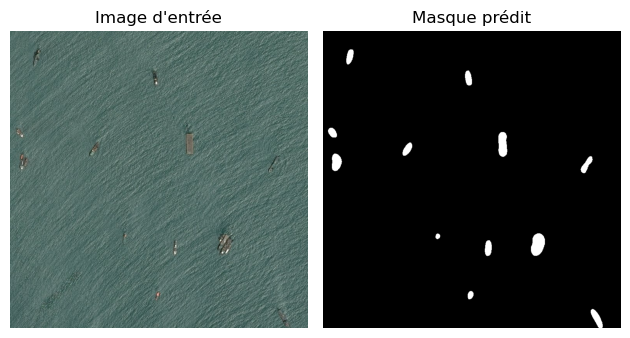

Loading predictions:  38%|███▊      | 3/8 [00:05<00:08,  1.80s/it]

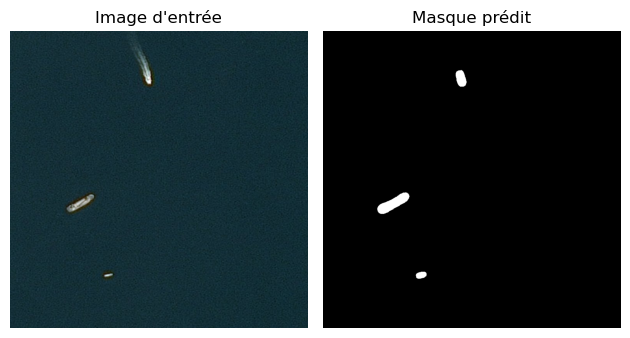

Loading predictions:  50%|█████     | 4/8 [00:07<00:07,  1.86s/it]

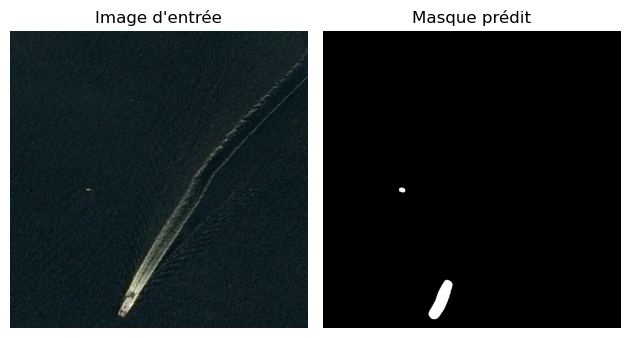

Loading predictions:  62%|██████▎   | 5/8 [00:09<00:05,  1.95s/it]

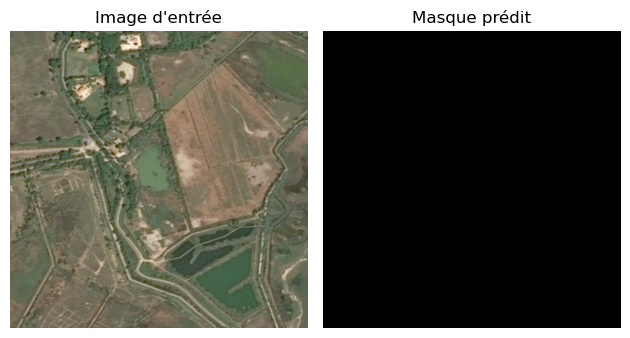

Loading predictions:  75%|███████▌  | 6/8 [00:11<00:04,  2.02s/it]

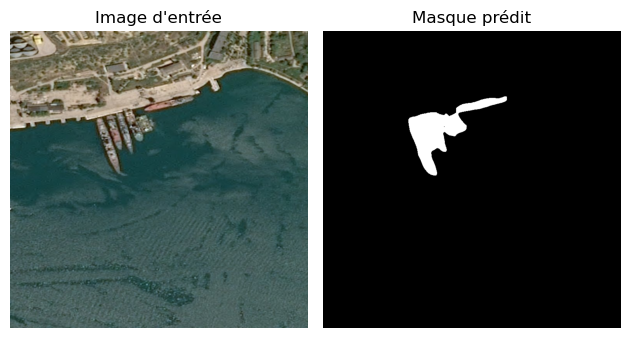

Loading predictions:  88%|████████▊ | 7/8 [00:13<00:01,  1.97s/it]

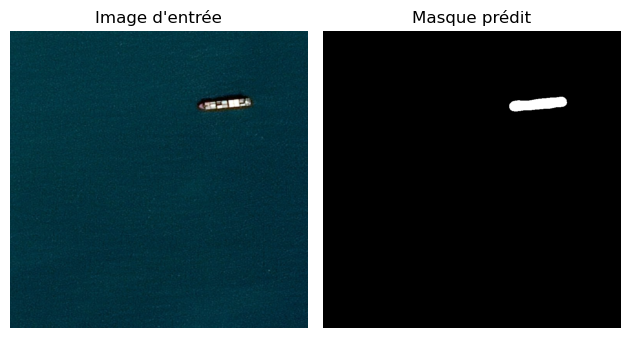

Loading predictions: 100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


In [4]:
model = get_model(
    num_classes=1,
    neural_network='Unet',
    encoder_name='efficientnet-b7',
    encoder_depth=5,
    activation='sigmoid'
)

data_augmentation = {
    # Geometric transformations
    'RandomRotation': (0, 180),
    'RandomVerticalFlip': 0.5,
    'RandomHorizontalFlip': 0.5,
    'RandomCrop': (256, 256),
    'RandomAffine': {
        'degrees': (-30, 30),     
        'translate': (0.1, 0.1), 
        'scale': (0.8, 1.2), 
        'shear': (-10, 10), 
        'p' : 0            
    },
    'RandomPerspective': {
        'distortion_scale': 0.5,
        'p': 0
    },

    # Radiometric transformations
    'ColorJitter': {
        'brightness': (0.5, 1.5),
        'contrast': (0.5, 1.5),
        'saturation': (0.5, 1.5),
        'hue': (-0.3, 0.3),
        'p': 0.5
    },
    'RandomGamma': {
        'gamma': (0.7, 1.5),
        'p': 0
    },
    'RandomGrayscale': 0,
    'RandomBrightness': {
        'brightness': (0.5, 1.5),
        'p': 0
    },
    'RandomContrast': {
        'contrast': (0.5, 1.5),
        'p': 0
    },
    'RandomSharpness': {
        'sharpness': (0.5, 2.0),
        'p': 0
    },
    'GaussianBlur': {
        'kernel_size': (5, 5),
        'sigma': (0.1, 2.0),
        'p' : 0.5
    }
}

log_dir = "tensorboard/logs"
logger = pl.loggers.TensorBoardLogger(log_dir, name="Boat_detector")

segmentation_model = SegmentationModel(
    model=model,
    optimizer_name='AdamW',
    log_every_n_steps=30,
    learning_rate=0.0001,
    loss='CombinedLoss',
    data_augmentation=data_augmentation,
    log_dir=log_dir,
    logger=logger
)

# Load pre-trained model weights
checkpoint = torch.load('../Pre_train_weights/UNet_boat_detector.ckpt')
segmentation_model.load_state_dict(checkpoint)
segmentation_model.eval()

# to make inferences about images
images, predicted_masks = evaluation(images, model=segmentation_model, binary=True)